# Stock Clustering with KMeans & GMM

This notebook implements an unsupervised machine learning pipeline to cluster ~500 publicly traded stocks based on financial and return data.

We:
- Standardize and log-transform ~20 financial indicators
- Use the elbow method to determine the optimal number of KMeans clusters
- Visualize clusters using PCA
- Compare KMeans and GMM results, including soft cluster probabilities
- Implement a custom GMM from scratch for deeper understanding

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [ ]:
## 1. Load and Standardize Data  

df = pd.read_csv('../data/old/data.csv')

cols = [
    "close_ma_30", 
    "close_ma_90", 
    "close_ma_200", 
    "volume_ma_30", 
    "volume_ma_90", 
    "volume_ma_200", 
    "currentRatio_ma", 
    "quickRatio_ma", 
    "returnOnEquity_ma", 
    "returnOnAssets_ma", 
    "netProfitMargin_ma", 
    "priceEarningsRatio_ma", 
    "priceBookValueRatio_ma", 
    "priceToSalesRatio_ma", 
    "freeCashFlowPerShare_ma", 
    "operatingCashFlowPerShare_ma", 
    "cashFlowToDebtRatio_ma", 
    "debtEquityRatio_ma", 
    "longTermDebtToCapitalization_ma", 
    "assetTurnover_ma", 
    "inventoryTurnover_ma"
]


scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[cols]))
df_scaled.columns = cols
#
# concat scaled colums

df = df.drop(cols, axis=1)
df_scaled = pd.concat([df, df_scaled], axis=1)

In [52]:
df_scaled.to_csv('../data/data_scaled.csv', index=False)

In [ ]:
## 2. Log Transform and Preprocess  

cols = list(df_scaled.columns)
cols.pop(0)

df_scaled.fillna(method='ffill', inplace=True)
df_log = np.log1p(df_scaled[cols] + 1e-6)
df_log.fillna(method='ffill', inplace=True)
df_log['symbol'] = df_scaled['symbol']

/var/folders/sz/y6mbyrnd7d1g13bfc3t_0q5c0000gn/T/ipykernel_45265/1550689925.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_scaled.fillna(method='ffill', inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/var/folders/sz/y6mbyrnd7d1g13bfc3t_0q5c0000gn/T/ipykernel_45265/1550689925.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_log.fillna(method='ffill', inplace=True)


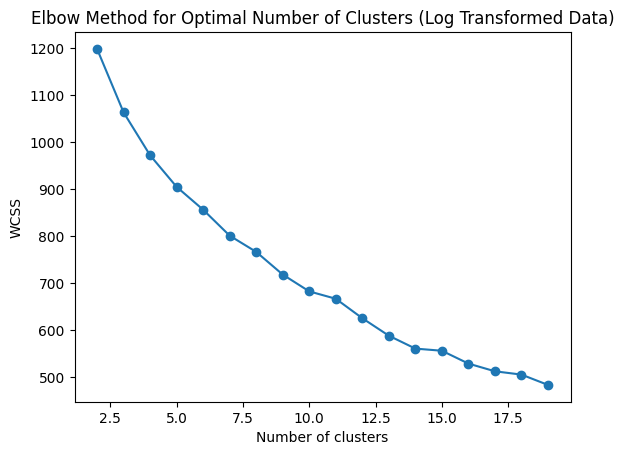

In [ ]:
## 3. Determine Optimal Clusters (Elbow Method) 

wcss_log = []
range_n_clusters = list(range(2, 20))

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(df_log[cols])
    wcss_log.append(kmeans.inertia_)

plt.plot(range_n_clusters, wcss_log, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters (Log Transformed Data)')
plt.show()

In [ ]:
# test for 6 clusters

kmeans_6 = KMeans(n_clusters=8, random_state=42, n_init=10)
df_log['cluster_6'] = kmeans_6.fit_predict(df_log[cols])

clusters_by_symbol_6 = df_log[['symbol', 'cluster_6']]
clusters_by_symbol_6

plt.hist(df_log['cluster_6'])
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

,symbol,cluster_6
0,APO,0
1,LII,7
2,WDAY,5
3,TPL,2
4,DELL,6
...,...,...
495,PPG,7
496,RTX,0
497,SLB,0
498,SO,0


In [57]:
clusters_by_symbol_6.to_csv('../data/k6ml2.csv', index=False)

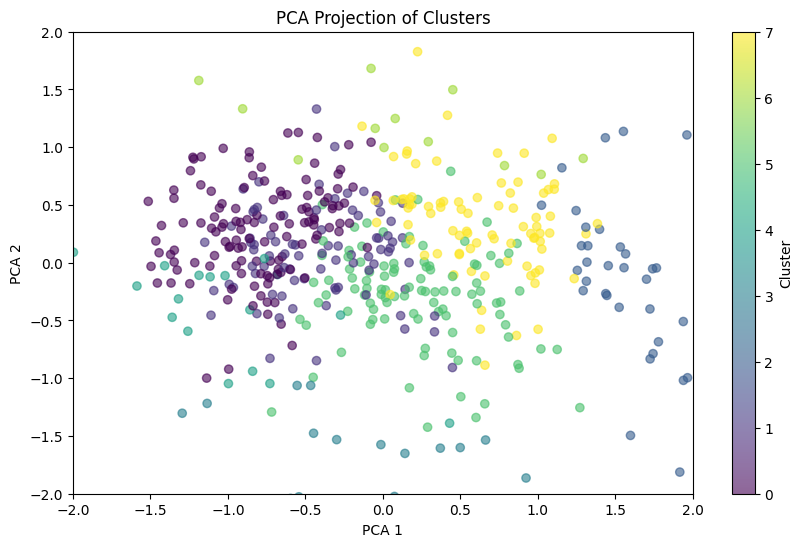

In [ ]:
## 4. KMeans Clustering and PCA Visualization

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
df_log['pca_1'], df_log['pca_2'] = zip(*pca.fit_transform(df_log[cols]))

plt.figure(figsize=(10,6))
plt.scatter(df_log['pca_1'], df_log['pca_2'], c=df_log['cluster_6'], cmap='viridis', alpha=0.6)
plt.xlabel("PCA 1")
plt.xlim(-2, 2)
plt.ylabel("PCA 2")
plt.ylim(-2, 2)
plt.title("PCA Projection of Clusters")
plt.colorbar(label="Cluster")
plt.show()

In [ ]:
## 5. GMM Clustering and PCA Visualization  

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=6, random_state=42)
df_log['gmm'] = gmm.fit_predict(df_log[cols])

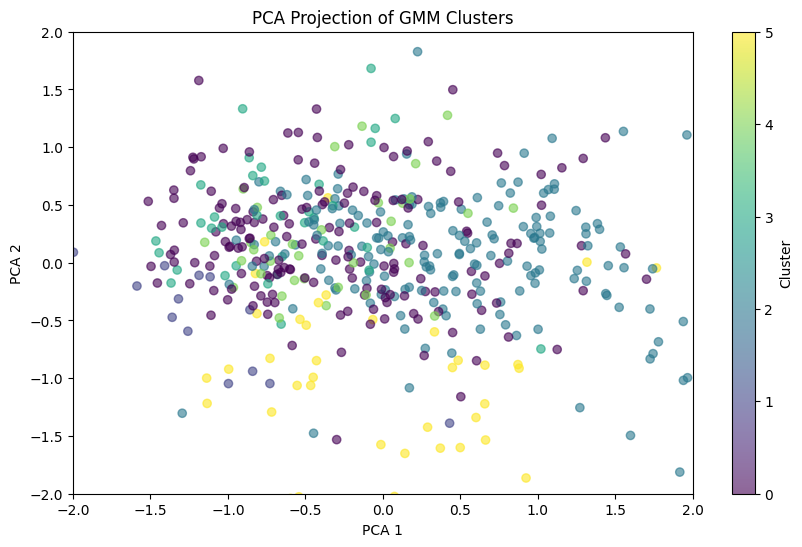

In [ ]:
pca = PCA(n_components=2)
df_log['pca_1'], df_log['pca_2'] = zip(*pca.fit_transform(df_log[cols]))

plt.figure(figsize=(10,6))
plt.scatter(df_log['pca_1'], df_log['pca_2'], c=df_log['gmm'], cmap='viridis', alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("PCA Projection of GMM Clusters")
plt.colorbar(label="Cluster")
plt.show()

In [ ]:
## 6. Custom GMM Implementation (Scratch) 

import numpy as np
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, n_components, n_iter=100, tol=1e-3, random_state=42):
        self.n_components = n_components
        self.n_iter = n_iter
        self.tol = tol
        np.random.seed(random_state)

    def initialize_parameters(self, X):
        self.n_samples, self.n_features = X.shape
        self.mean = X[np.random.choice(self.n_samples, self.n_components, replace=False)]
        self.covs = np.array([np.cov(X.T) + np.eye(self.n_features) * 1e-6 for _ in range(self.n_components)])
        self.weights = np.ones(self.n_components) / self.n_components

    def e_step(self, X):
        """Expectation step: Compute responsibilities"""
        n_samples = X.shape[0]
        self.responsibility = np.zeros((n_samples, self.n_components))

        for i in range(self.n_components):
            try:
                self.responsibility[:, i] = self.weights[i] * multivariate_normal.pdf(
                    X, mean=self.mean[i], cov=self.covs[i], allow_singular=True
                )
            except ValueError:
                print(f"Covariance matrix is singular for component {i}, adding regularization.")
                self.covs[i] += np.eye(self.n_features) * 1e-6  # Regularization

        # avoid nan 
        total_responsibility = self.responsibility.sum(axis=1, keepdims=True)
        total_responsibility[total_responsibility == 0] = 1e-6  # Prevent division by zero
        self.responsibility /= total_responsibility

    def m_step(self, X):
        for i in range(self.n_components):
            resp_sum = self.responsibility[:, i].sum()
            if resp_sum == 0:
                print(f"Component {i} has zero responsibility, skipping update.")
                continue

            self.weights[i] = resp_sum / self.n_samples
            self.mean[i] = np.sum(self.responsibility[:, i, None] * X, axis=0) / resp_sum
            diff = X - self.mean[i]

            # Ensure covariance matrix is valid
            weighted_diff = self.responsibility[:, i][:, None] * diff
            self.covs[i] = np.dot(weighted_diff.T, diff) / resp_sum + np.eye(self.n_features) * 1e-6

    def log_likelihood(self, X):
        ll = 0
        for n in range(X.shape[0]):
            component_pdfs = [
                self.weights[k] * multivariate_normal.pdf(X[n], mean=self.mean[k], cov=self.covs[k])
                for k in range(self.n_components)
            ]
            ll += np.log(np.sum(component_pdfs) + 1e-12)
        return ll

    def fit(self, X):
        self.initialize_parameters(X)

        for _ in range(self.n_iter):
            prev_mean = self.mean.copy()
            self.e_step(X)
            self.m_step(X)

            # Check convergence
            if np.linalg.norm(self.mean - prev_mean) < self.tol:
                break

    def predict(self, X):
        self.e_step(X)
        return np.argmax(self.responsibility, axis=1)


In [99]:
X = df_log[cols].values
gmm = GMM(n_components=10)
gmm.fit(X)
df_log['gmm_custom'] = gmm.predict(X)

In [101]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X, df_log['gmm_custom'])
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: -0.0447


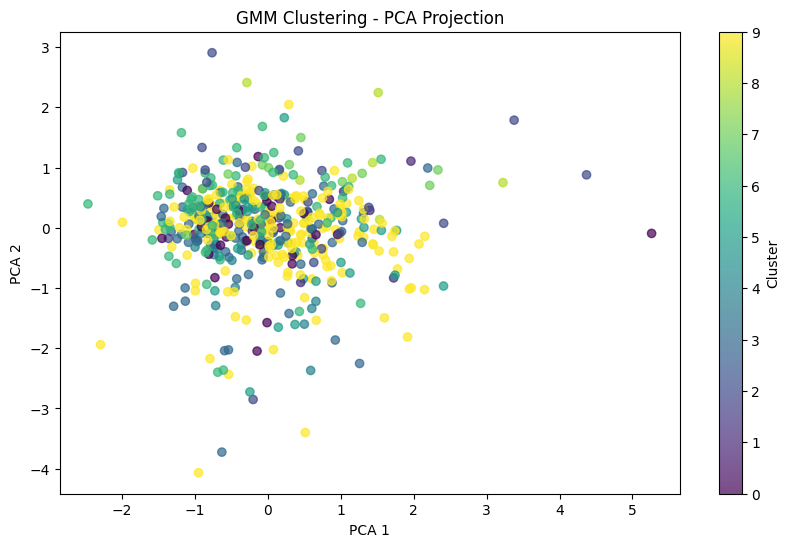

In [100]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X) 
df_log['pca_1'], df_log['pca_2'] = X_pca[:, 0], X_pca[:, 1]

#  plot
plt.figure(figsize=(10, 6))
plt.scatter(df_log['pca_1'], df_log['pca_2'], c=df_log['gmm_custom'], cmap='viridis', alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("GMM Clustering - PCA Projection")
plt.colorbar(label="Cluster")
plt.show()


In [93]:
gmm = GaussianMixture(n_components=6, random_state=42)
gmm.fit(X)
probs = gmm.predict_proba(X)

# Show probability distribution of first 10 rows
import pandas as pd
pd.DataFrame(probs[:10], columns=[f'Cluster {i}' for i in range(6)])

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,1.000000e+00,0.0,4.199540e-11,1.788117e-165,3.642557e-142,4.495175e-52
1,1.806641e-04,0.0,9.998193e-01,7.676950e-314,6.124732e-305,9.477571e-59
2,1.775291e-243,0.0,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
3,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.000000e+00,5.253497e-145
4,9.058828e-05,0.0,5.351092e-15,9.999094e-01,0.000000e+00,0.000000e+00
5,2.118951e-125,0.0,1.000000e+00,3.262408e-251,0.000000e+00,1.617820e-37
6,7.874125e-67,1.0,0.000000e+00,0.000000e+00,0.000000e+00,4.223983e-173
7,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
8,1.000000e+00,0.0,5.687697e-37,4.179472e-77,0.000000e+00,1.522332e-23
9,1.000000e+00,0.0,3.504549e-36,3.554061e-162,6.809616e-293,0.000000e+00
